In [12]:
import numpy
import scipy
import scipy.special
import scipy.stats
from sklearn import metrics
import matplotlib.pyplot as plt
import irp.pp, irp.map, irp.em
%load_ext ipython_unittest.dojo
%matplotlib inline

The ipython_unittest.dojo extension is already loaded. To reload it, use:
  %reload_ext ipython_unittest.dojo


### Helpers

Let's define normalized versions of distribution objects, where the density is defined by expected density. The normalization factor for  Exponential distribution is $\frac 1 {2 \cdot scale}$, and for Gamma distribution is $\frac{\Gamma\left( 2\cdot a-1\right) }{{2}^{2\cdot a - 1} \cdot {{\Gamma\left( a\right) }^{2}}\cdot \mathit{scale}}$.

In [ ]:
class Normdist(object):
    def __init__(self, dist, norm):
        self.dist = dist
        self.norm = norm
        
    def pdf(self, x):
        d = self.dist.pdf(x)
        return d/self.norm
    
    def __getattr__(self, name):
        return getattr(self.dist, name)
    
def nexpon(scale):
    return Normdist(scipy.stats.expon(scale=scale), 1/(2. * scale))

def ngamma(a, scale):
    return Normdist(scipy.stats.gamma(a=a, scale=scale),
                    scipy.special.gamma(2 * a   - 1) /
                    (2 ** (2 * a - 1) * scipy.special.gamma(a) ** 2 * scale))

# Intrusions in Marked Renewal Processes

This notebook is a part of empirical evaluation for the paper [](Intrusions in Marked Renewal Processes). 

## Evaluation on Synthetic data

Synthetic data are sampled from a marked renewal process of known shape and parameters. 

### Generative model

We first define a generative model for the data in Python. The model produces both normal entries and intrusions.

In [39]:
def generate(N, pi, F, G, Gi=nexpon(scale=1)):
    """
    Generates a data sequence with possible intrusion.
    Accepts:
        N - the number of events,
        F - interval distribution,
        G - mark distribution,
        Gi - intrusion mark distribution.
    Returns:
        [t_s, t_e, [[t_i, y_i] ...], [z_i ...]]
    where
        t_s - start of the interval
        t_e - end of the interval
        t_i - arrival time of the ith event
        y_i - mark of the ith event
        z_i - 1 if the event belongs to the intrusion, 0 otherwise.
    """
    # Normal events
    K = scipy.stats.binom.rvs(N, pi)
    ts = numpy.cumsum(F.rvs(size=N - K))
    ys = G.rvs(size=N - K)
    t_s = scipy.stats.uniform.rvs(0, ts[0])
    t_e = ts[-1] + t_s
    
    # Intrusion events
    ti_s, ti_e = scipy.stats.uniform.rvs(t_s, t_e - t_s, size=2)
    if ti_e < ti_s:
        ti_s, ti_e = ti_e, ti_s
    tis = scipy.stats.uniform.rvs(ti_s, ti_e - ti_s, size=K)
    yis = Gi.rvs(size=K)
    
    # Merge them into a single list
    SZ = [(t, s, 0) for t, s in zip(ts, ys)] + [(t, s, 1) for t, s in zip(tis, yis)]
    SZ.sort(key=lambda x: x[0])
    S = [(x, y) for x, y, _ in SZ]
    Z = [z for _, _, z in SZ]
    return [t_s, t_e, S, Z]

The event probability of belonging to an intrusion is chosen so that the probability of an intrusion is as given.

In [40]:
def get_pi(N, p=0.5):
    """"""
    return 1 - (1 - p)**(1. / N)

In [41]:
%%unittest
"""Check that generated data set is balanced as specified"""
for p in [0.25, 0.5, 0.75]:
    assert abs(scipy.stats.binom.pmf(0, 100, get_pi(100, p)) - (1 - p)) < 1E-6

<IPython.core.display.Javascript object>

.
----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


<IPython.core.display.Javascript object>

<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [42]:
%%unittest
"""check that traces contain intrusion with requested probability"""
N = 100
p = 0.5
pi = get_pi(N, p)
NITER = 1000
ind = 0
for i in range(NITER):
    t_s, t_e, S, Z = generate(N, pi, 
        F=scipy.stats.gamma(a=2, scale=1), 
        G=scipy.stats.expon(scale=1),
        Gi=scipy.stats.expon(scale=10))
    ind += any(Z)
assert abs(ind/NITER - p) < 0.05

<IPython.core.display.Javascript object>

.
----------------------------------------------------------------------
Ran 1 test in 3.500s

OK


<IPython.core.display.Javascript object>

<unittest.runner.TextTestResult run=1 errors=0 failures=0>

### Evaluation dataset

We can generate a data set using the generative model now. The data consists of tensors `T`, `S`, and `Z` containing intervals, samples and labels for the samples, correspondingly. We generate datasets for `p = 0.5` and `p = 0.995` of intrusion per trace. The first set is balanced, the second has longer intrusions with higher probability.

We also vary the scale of the marks of the intrusion events.

In [43]:
NSAMPLES = 1000
N = 20
ps = [0.0125, 0.025, 0.05, 0.1, 0.2]
iscales = [1, 5]

def sfname(t, p, iscale):
    return format("../data/x-{}-synthetic-p={}-iscale={}.npy".format(t, p, iscale))

In [44]:
GENERATE = False # Change to True to regenerate the data set

fa = 4
fscale = 1
gscale = 1

if GENERATE:
    print("p\tiscale")
    for p in ps:
        for iscale in iscales:
            print("{:.4f}\t{:.4f}"
                  .format(p, iscale), end=" ")
            pi = get_pi(N, p)
            T = []
            S = []
            Z = []
            # We create a balanced data set here, otherwise
            # positive samples will be too sparse for realistic
            # values of P
            for i in range(NSAMPLES):
                while True:
                    t_s, t_e, s, z = generate(N, pi, 
                        F=scipy.stats.gamma(a=fa, scale=fscale), 
                        G=scipy.stats.expon(scale=gscale),
                        Gi=scipy.stats.expon(scale=iscale))
                    if (sum(z) == 0) == (numpy.random.rand() < p):
                        break
                T.append([t_s, t_e])
                S.append(s)
                Z.append(z)
            T = numpy.array(T)
            S = numpy.array(S)
            Z = numpy.array(Z)
            numpy.save(sfname("t", p, iscale), T, False)
            numpy.save(sfname("s", p, iscale), S, False)
            numpy.save(sfname("z", p, iscale), Z, False)
            print("✓")

For analysis, we re-load the dataset. The dataset is a list of records, one record for each combination of parameters `p` and `iscale`.

In [45]:
DATASETS = []
for p in ps:
    for iscale in iscales:
        T = numpy.load(sfname("t", p, iscale))
        S = numpy.load(sfname("s", p, iscale))
        Z = numpy.load(sfname("z", p, iscale))
        DATASETS.append({"p": p,
                         "iscale": iscale,
                         "T": T,
                         "S": S,
                         "Z": Z})

With the dataset at hand, we are ready for the evaluation.

### Experiments with algorithms

#### Posterior Probabilities

In [46]:
def posteriors(ds, EM, F, G):
    P = numpy.ndarray(ds["S"].shape[0])
    M = numpy.ndarray(ds["S"].shape[:2])
    L = numpy.ndarray(M.shape)
    pi = get_pi(ds["S"].shape[1], ds["p"])
    ds["P"] = P
    for i in range(ds["S"].shape[0]):
        S = ds["S"][i, :]
        t_s, t_e = ds["T"][i, :]
        if EM:
            F, G, L[i, :] = irp.em.parameters(t_s, t_e, S, pi)
        else:
            L[i, :] = irp.map.labels(t_s, t_e, S, pi, F, G)
        P[i] = irp.pp.intrusion(t_s, t_e, S, pi, F, G)
        M[i, :] = irp.pp.marginal(t_s, t_e, S, pi, F, G)
    ds["P" + str(EM)] = P
    ds["M" + str(EM)] = M
    ds["L" + str(EM)] = L

Let's now compute posteriors for all samples in all data sets.

In [ ]:
F=ngamma(a=fa, scale=fscale)
G=nexpon(scale=gscale)
print("EM\tp\tiscale")
for ds in DATASETS:
    for EM in [False, True]:
        print("{}\t{:.4f}\t{:.4f}"
            .format(EM, ds["p"], ds["iscale"]), end=" ")
        if ("P" + str(EM)) not in ds:
            posteriors(ds, EM, F, G)
        print("✓")

EM	p	iscale
False	0.0125	1.0000 ✓
True	0.0125	1.0000 ✓
False	0.0125	5.0000 ✓
True	0.0125	5.0000 ✓
False	0.0250	1.0000 ✓
True	0.0250	1.0000 ✓
False	0.0250	5.0000 ✓
True	0.0250	5.0000 ✓
False	0.0500	1.0000 ✓
True	0.0500	1.0000 ✓
False	0.0500	5.0000 ✓
True	0.0500	5.0000 ✓
False	0.1000	1.0000 ✓
True	0.1000	1.0000 ✓
False	0.1000	5.0000 ✓
True	0.1000	5.0000 

Based on the computed results, we can obtain statistics on intrusion detection.

#### Basic analytics

First, we compute just the average intrusion probability in positive and negative samples. The greater the difference between these two numbers, the higher is the detection accuracy.

In [ ]:
print("EM\tp\tiscale\tnP\tpP\tnN\tpN")
ps = set()
iscales = set()
curves = {False: {}, True: {}}
for ds in DATASETS:
    for EM in [False, True]:
        pP = 0.
        pN = 0.
        nP = 0
        nN = 0
        for i in range(ds["S"].shape[0]):
            if sum(ds["Z"][i, :]) > 0:
                pP += ds["P" + str(EM)][i]
                nP += 1
            else:
                pN += ds["P" + str(EM)][i]
                nN += 1
        pP /= max(nP, 1)
        pN /= max(nN, 1)
        if ds["iscale"] not in curves[EM]:
            curves[EM][ds["iscale"]] = {}
        ps.add(ds["p"])
        iscales.add(ds["iscale"])
        curves[EM][ds["isca le"]][ds["p"]] = [pP, pN]
        print("{}\t{:.4f}\t{:.4f}\t{:d}\t{:.4f}\t{:d}\t{:.4f}"
              .format(EM, ds["p"], ds["iscale"], nP, pP, nN, pN))
ps = sorted(list(ps))
iscales = sorted(list(iscales))

Let's visualize the average alert score as function of intrusion probability.

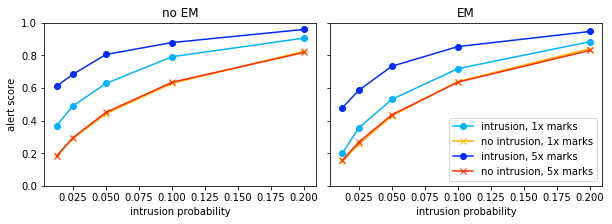

In [13]:
xs = ps
f_s_aas, (spnoem, spem) = plt.subplots(1, 2, sharey=True)
f_s_aas.subplots_adjust(wspace=0.05)
f_s_aas.set_figwidth(10)
f_s_aas.set_figheight(3)
spnoem.set_title("Known process")
spem.set_title("EM")
spnoem.set_ylabel("alert score")
for sp in [spnoem, spem]:
    sp.set_xlabel("intrusion probability")
    sp.set_ylim(0, 1)
for (em, sp) in [(False, spnoem), (True, spem)]:
    for iscale in iscales:
        ys = numpy.array([curves[em][iscale][p] for p in ps])
        sp.plot(xs, ys[:, 0], marker='o', color=[x**iscale for x in (0, 0.7, 1)],
                label="intrusion, {}x marks".format(iscale))
        sp.plot(xs, ys[:, 1], marker='x', color=[x**iscale for x in (1, 0.7, 0)],
                label="no intrusion, {}x marks".format(iscale))
handles, labels = spem.get_legend_handles_labels()
spem.legend(handles, labels)
f_s_aas.savefig('../figures/synthetic-alert-score.pdf')

#### Fine-grained metrics

We also obtain more fine-grained metrics of detection accuracy. 

* AUC on total intrusion probability
* AUC on marginal event probabilities
* Jackard similarity for MAP

#### AUC

EM	p	iscale	auc
False	0.0125	1.0000	0.7022
True	0.0125	1.0000	0.6144
False	0.0125	5.0000	0.8492
True	0.0125	5.0000	0.7877
False	0.0250	1.0000	0.7140
True	0.0250	1.0000	0.6400
False	0.0250	5.0000	0.8345
True	0.0250	5.0000	0.7887
False	0.0500	1.0000	0.7096
True	0.0500	1.0000	0.6339
False	0.0500	5.0000	0.8566
True	0.0500	5.0000	0.7956
False	0.1000	1.0000	0.7242
True	0.1000	1.0000	0.6141
False	0.1000	5.0000	0.8367
True	0.1000	5.0000	0.7882
False	0.2000	1.0000	0.7021
True	0.2000	1.0000	0.5938
False	0.2000	5.0000	0.8561
True	0.2000	5.0000	0.7841


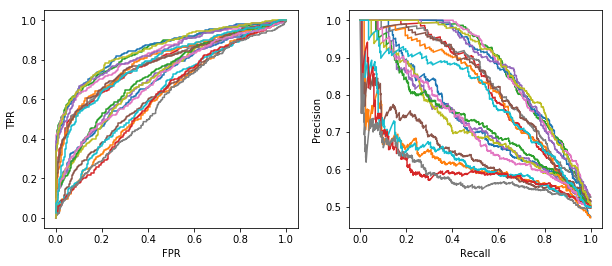

In [14]:
print("EM\tp\tiscale\tauc")
pcurves = {False: {}, True: {}}
f, (sproc, sppr) = plt.subplots(1, 2)
f.set_figwidth(10)
sproc.set_xlabel("FPR")
sproc.set_ylabel("TPR")
sppr.set_xlabel("Recall")
sppr.set_ylabel("Precision")
for ds in DATASETS:
    for EM in [False, True]:
        fpr, tpr, thresholds = metrics.roc_curve(ds["Z"].sum(axis=1) > 0,
                                                 ds["P" + str(EM)], 
                                                 pos_label=True)
        precision, recall, thresholds = metrics.precision_recall_curve(
                                                 ds["Z"].sum(axis=1) > 0,
                                                 ds["P" + str(EM)],
                                                 pos_label=True)
        sproc.plot(fpr, tpr)
        sppr.plot(recall, precision)
        auc = metrics.auc(fpr, tpr)
        if ds["iscale"] not in pcurves[EM]:
            pcurves[EM][ds["iscale"]] = {}
        pcurves[EM][ds["iscale"]][ds["p"]] = auc
        print("{}\t{:.4f}\t{:.4f}\t{:.4f}"
              .format(EM, ds["p"], ds["iscale"], auc))

Let's visualize AUC:

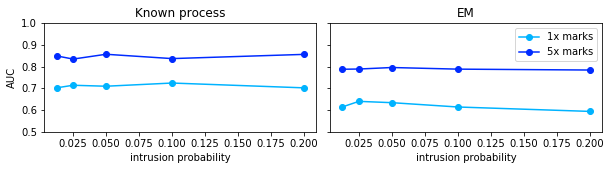

In [15]:
xs = ps
f_s_pauc, (spnoem, spem) = plt.subplots(1, 2, sharey=True)
f_s_pauc.subplots_adjust(wspace=0.05)
f_s_pauc.set_figwidth(10)
f_s_pauc.set_figheight(2)
spnoem.set_title("Known process")
spem.set_title("EM")
spnoem.set_ylabel("AUC")
for sp in [spnoem, spem]:
    sp.set_xlabel("intrusion probability")
    sp.set_ylim(0.5, 1)
    sp.axhline(y=0.5, color='black', lw=1, ls='dashed')
for (em, sp) in [(False, spnoem), (True, spem)]:
    for iscale in iscales:
        ys = numpy.array([pcurves[em][iscale][p] for p in ps])
        sp.plot(xs, ys, marker='o', color=[x**iscale for x in (0, 0.7, 1)],
                label="{}x marks".format(iscale))
handles, labels = spem.get_legend_handles_labels()
spem.legend(handles, labels)
f_s_pauc.savefig("../figures/synthetic-auc-per-log.pdf")

#### AUC of individual events

EM	p	iscale	auc
False	0.0125	1.0000	0.8285
True	0.0125	1.0000	0.8044
False	0.0125	5.0000	0.9385
True	0.0125	5.0000	0.9297
False	0.0250	1.0000	0.8039
True	0.0250	1.0000	0.7764
False	0.0250	5.0000	0.9376
True	0.0250	5.0000	0.9255
False	0.0500	1.0000	0.8093
True	0.0500	1.0000	0.7866
False	0.0500	5.0000	0.9415
True	0.0500	5.0000	0.9320
False	0.1000	1.0000	0.8161
True	0.1000	1.0000	0.7893
False	0.1000	5.0000	0.9303
True	0.1000	5.0000	0.9201
False	0.2000	1.0000	0.8023
True	0.2000	1.0000	0.7649
False	0.2000	5.0000	0.9298
True	0.2000	5.0000	0.9145


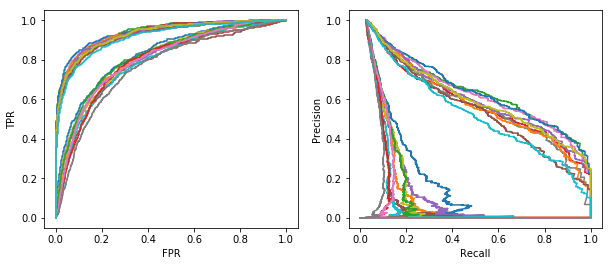

In [16]:
print("EM\tp\tiscale\tauc")
lcurves = {False: {}, True: {}}
f, (sproc, sppr) = plt.subplots(1, 2)
f.set_figwidth(10)
sproc.set_xlabel("FPR")
sproc.set_ylabel("TPR")
sppr.set_xlabel("Recall")
sppr.set_ylabel("Precision")
for ds in DATASETS:
    for EM in [False, True]:
        fpr, tpr, thresholds = metrics.roc_curve(ds["Z"].reshape((-1, 1)),
                                                 ds["M" + str(EM)].reshape((-1, 1)), 
                                                 pos_label=1)
        precision, recall, thresholds = metrics.precision_recall_curve(
                                                 ds["Z"].reshape((-1, 1)),
                                                 ds["M" + str(EM)].reshape((-1, 1)), 
                                                 pos_label=1)
        auc = metrics.auc(fpr, tpr)
        sproc.plot(fpr, tpr)
        sppr.plot(precision, recall)
        if ds["iscale"] not in lcurves[EM]:
            lcurves[EM][ds["iscale"]] = {}
        lcurves[EM][ds["iscale"]][ds["p"]] = auc
        print("{}\t{:.4f}\t{:.4f}\t{:.4f}"
              .format(EM, ds["p"], ds["iscale"], auc))

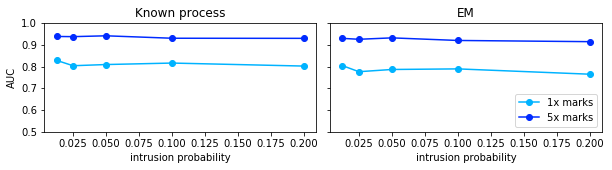

In [17]:
xs = ps
f_s_mauc, (spnoem, spem) = plt.subplots(1, 2, sharey=True)
f_s_mauc.subplots_adjust(wspace=0.05)
f_s_mauc.set_figwidth(10)
f_s_mauc.set_figheight(2)
spnoem.set_title("Known process")
spem.set_title("EM")
spnoem.set_ylabel("AUC")
for sp in [spnoem, spem]:
    sp.set_xlabel("intrusion probability")
    sp.set_ylim(0.5, 1)
for (em, sp) in [(False, spnoem), (True, spem)]:
    for iscale in iscales:
        ys = numpy.array([lcurves[em][iscale][p] for p in ps])
        sp.plot(xs, ys, marker='o', color=[x**iscale for x in (0, 0.7, 1)],
                label="{}x marks".format(iscale))
handles, labels = spem.get_legend_handles_labels()
spem.legend(handles, labels, loc='lower right')
f_s_mauc.savefig("../figures/synthetic-auc-per-event.pdf")

#### Jaccard similarity

In [18]:
print("EM\tp\tiscale\tjss")
jcurves = {False: {}, True: {}}
for ds in DATASETS:
    for EM in [False, True]:
        jss = metrics.jaccard_similarity_score(ds["Z"], ds["L" + str(EM)])
        if ds["iscale"] not in jcurves[EM]:
            jcurves[EM][ds["iscale"]] = {}
        jcurves[EM][ds["iscale"]][ds["p"]] = jss
        print("{}\t{:.4f}\t{:.4f}\t{:.4f}"
              .format(EM, ds["p"], ds["iscale"], jss))

EM	p	iscale	jss
False	0.0125	1.0000	0.5155
True	0.0125	1.0000	0.4880
False	0.0125	5.0000	0.7155
True	0.0125	5.0000	0.6550
False	0.0250	1.0000	0.5100
True	0.0250	1.0000	0.4970
False	0.0250	5.0000	0.7070
True	0.0250	5.0000	0.6480
False	0.0500	1.0000	0.4787
True	0.0500	1.0000	0.4713
False	0.0500	5.0000	0.7032
True	0.0500	5.0000	0.6913
False	0.1000	1.0000	0.4607
True	0.1000	1.0000	0.4268
False	0.1000	5.0000	0.6224
True	0.1000	5.0000	0.6372
False	0.2000	1.0000	0.3295
True	0.2000	1.0000	0.3251
False	0.2000	5.0000	0.5204
True	0.2000	5.0000	0.5270


Let's visualize Jaccard score:

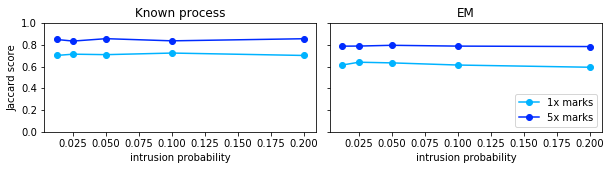

In [19]:
xs = ps
f_s_jss, (spnoem, spem) = plt.subplots(1, 2, sharey=True)
f_s_jss.subplots_adjust(wspace=0.05)
f_s_jss.set_figwidth(10)
f_s_jss.set_figheight(2)
spnoem.set_title("Known process")
spem.set_title("EM")
spnoem.set_ylabel("Jaccard score")
for sp in [spnoem, spem]:
    sp.set_xlabel("intrusion probability")
    sp.set_ylim(0, 1)
for (em, sp) in [(False, spnoem), (True, spem)]:
    for iscale in iscales:
        ys = numpy.array([pcurves[em][iscale][p] for p in ps])
        sp.plot(xs, ys, marker='o', color=[x**iscale for x in (0, 0.7, 1)],
                label="{}x marks".format(iscale))
handles, labels = spem.get_legend_handles_labels()
spem.legend(handles, labels, loc='lower right')
f_s_jss.savefig("../figures/synthetic-jaccard-score.pdf")

## Evaluation on anonymized real-world data

In [25]:
def cfname(t, intr):
    return format("../data/{}-collected-{}.npy".format(t, intr))

The dataset as given is split into positive and negative samples. We load the dataset and concatenate both parts.

In [26]:
Ss = []
Zs = []
for intr in ["negative", "positive"]:
    Ss.append(numpy.load(cfname("s", intr)))
    Zs.append(numpy.load(cfname("z", intr)))
ds = {}
ds["S"] = numpy.concatenate(Ss, axis=0)
ds["Z"] = numpy.concatenate(Zs, axis=0)
ds["T"] = numpy.array([[0., 1.]] * ds["S"].shape[0])
assert ds["S"].shape[0] == ds["Z"].shape[0]

We shuffle samples in the data set and split it into the training and testing data set. We will use the training dataset to estimate prior probability of intrusion.

In [43]:
NSAMPLES, N, _ = ds["S"].shape
TRAIN_FRACTION = 10

indices = numpy.array(range(NSAMPLES))
numpy.random.shuffle(indices)

ds["S"] = ds["S"][indices]
ds["Z"] = ds["Z"][indices]

print("{} samples, {} time points per sample".format(NSAMPLES, N))

train_indices = indices[:len(indices) // TRAIN_FRACTION]
test_indices = indices[len(indices) // TRAIN_FRACTION:]

ds_train = {}
ds_test = {}
for key in ["S", "Z", "T"]:
    ds_train[key] = ds[key][train_indices]
    ds_test[key] = ds[key][test_indices]

1000 samples, 50 time points per sample


p	pauc	mauc	jss
0.0010	0.6836	0.9206	0.560000
0.0030	0.6836	0.9206	0.560000
0.0100	0.6836	0.9207	0.560000
0.0500	0.6836	0.9212	0.575000
0.2000	0.6828	0.9212	0.580000
0.8000	0.6828	0.9207	0.575000
pbest = 0.0500


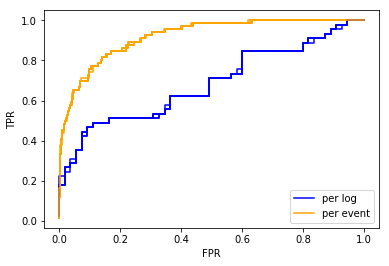

In [45]:
ps = [0.001, 0.003, 0.01, 0.05, 0.2, 0.8]
print("p\tpauc\tmauc\tjss")
f, plot = plt.subplots(1, 1)
plot.set_xlabel("FPR")
plot.set_ylabel("TPR")
maxauc = 0.
pbest = 0.
for p in ps:
    ds_train["p"] = p
    posteriors(ds_train, EM=True, F=None, G=None)
    fpr, tpr, thresholds = metrics.roc_curve(ds_train["Z"].sum(axis=1) > 0,
                                             ds_train["PTrue"], 
                                             pos_label=True)
    pauc = metrics.auc(fpr, tpr)
    plot.plot(fpr, tpr, c='blue', label='per log')

    fpr, tpr, thresholds = metrics.roc_curve(ds_train["Z"].reshape(-1) > 0,
                                             ds_train["MTrue"].reshape(-1), 
                                             pos_label=True)
    mauc = metrics.auc(fpr, tpr)
    plot.plot(fpr, tpr, c='orange', label='per event')

    jss = metrics.jaccard_similarity_score(ds_train["Z"], ds_train["L" + str(EM)])

    print("{:.4f}\t{:.4f}\t{:.4f}\t{:4f}".format(p, pauc, mauc, jss))
    
    if mauc*pauc > maxauc:
        pbest = p
        maxauc = mauc*pauc
 
print("pbest = {:.4f}".format(pbest))

handles, labels = plot.get_legend_handles_labels()
plot.legend(handles[-2:], labels[-2:])

We chose $p$, the prior intrusion probability, to maximize the AUC. With $p$ chosen, we  evaluate the algorithm on the test dataset. 

per-log AUC: 0.735317
per-event AUC: 0.915634
Jaccard similarity score: 0.6172


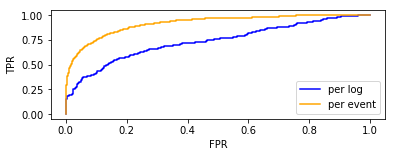

In [24]:
ds_test["p"] = pbest

f_a_roc, plot = plt.subplots(1, 1)
f_a_roc.set_figheight(2)
plot.set_xlabel("FPR")
plot.set_ylabel("TPR")

posteriors(ds_test, EM=True, F=None, G=None)

fpr, tpr, thresholds = metrics.roc_curve(ds_test["Z"].sum(axis=1) > 0,
                                         ds_test["PTrue"], 
                                         pos_label=True)
pauc = metrics.auc(fpr, tpr)
plot.plot(fpr, tpr, c='blue', label='per log')

fpr, tpr, thresholds = metrics.roc_curve(ds_test["Z"].reshape(-1) > 0,
                                         ds_test["MTrue"].reshape(-1), 
                                         pos_label=True)
mauc = metrics.auc(fpr, tpr)
plot.plot(fpr, tpr, c='orange', label='per event')

jss = metrics.jaccard_similarity_score(ds_test["Z"], ds_test["L" + str(EM)])

handles, labels = plot.get_legend_handles_labels()
plot.legend(handles[-2:], labels[-2:])

print("per-log AUC: {:4f}\nper-event AUC: {:4f}\nJaccard similarity score: {:.4f}"
      .format(pauc, mauc, jss))
f_a_roc.savefig("../figures/anonymized-roc.pdf")